In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn as sklearn
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold

In [2]:
# Load processed data features
data_features = pd.read_csv('processed_data/data_features.csv', header=[0,1], index_col=0, parse_dates=True)
# Forward fill missing values
data_features = data_features.ffill()

# Quick look at the data
print('features :' + str(data_features.keys().get_level_values(1).unique()))
data_features.head()

features :Index(['Stochastic', 'William', 'Basic_Mid', 'Close_to_High', 'Close_to_Low',
       'DD_Return', 'Close_MA_5', 'Close_STD_5', 'Close_GROWTH_5',
       'Close_Above_MA_5',
       ...
       'Close_to_Low_lag_2', 'Close_to_Low_lag_3', 'Close_to_Low_lag_4',
       'Close_to_Low_lag_5', 'DD_Return_lag_1', 'DD_Return_lag_2',
       'DD_Return_lag_3', 'DD_Return_lag_4', 'DD_Return_lag_5', 'Signal'],
      dtype='object', length=178)


CDE                                                  \
           Stochastic   William  Basic_Mid Close_to_High Close_to_Low   
Date                                                                    
2005-01-03   0.090908  0.909092  38.100000      0.026455    -0.002645   
2005-01-04   0.142857  0.857143  36.600000      0.049862    -0.008310   
2005-01-05   0.125001  0.874999  36.300001      0.038997    -0.005571   
2005-01-06   0.210527  0.789473  35.366666      0.042857    -0.011429   
2005-01-07   0.499998  0.500002  35.300001      0.016997    -0.016997   

                                                                             \
           DD_Return Close_MA_5 Close_STD_5 Close_GROWTH_5 Close_Above_MA_5   
Date                                                                          
2005-01-03       NaN        NaN         NaN            NaN                0   
2005-01-04 -0.044974        NaN         NaN            NaN                0   
2005-01-05 -0.005540        NaN         NaN            NaN                0   
2005-01-06 -0.025070        NaN         NaN            NaN                0   
2005-01-07  0.008571   1.020397    0.030247            NaN                1   

            ...               LRCX                                        \
            ... Close_to_Low_lag_2 Close_to_Low_lag_3 Close_to_Low_lag_4   
Date        ...                                                            
2005-01-03  ...                NaN                NaN                NaN   
2005-01-04  ...                NaN                NaN                NaN   
2005-01-05  ...          -0.002519                NaN                NaN   
2005-01-06  ...          -0.023143          -0.002519                NaN   
2005-01-07  ...          -0.002705          -0.023143          -0.002519   

                                                                               \
           Close_to_Low_lag_5 DD_Return_lag_1 DD_Return_lag_2 DD_Return_lag_3   
Date                                                                            
2005-01-03                NaN             NaN             NaN             NaN   
2005-01-04                NaN             NaN             NaN             NaN   
2005-01-05                NaN       -0.035984             NaN             NaN   
2005-01-06                NaN       -0.033968       -0.035984             NaN   
2005-01-07                NaN       -0.007342       -0.033968       -0.035984   

                                                   
           DD_Return_lag_4 DD_Return_lag_5 Signal  
Date                                               
2005-01-03             NaN             NaN      0  
2005-01-04             NaN             NaN     -1  
2005-01-05             NaN             NaN     -1  
2005-01-06             NaN             NaN     -1  
2005-01-07             NaN             NaN      0  

[5 rows x 24564 columns]

In [3]:
# Filter data_features to include only rows after the date N due to feature availability
N = 151
filtered_data = data_features[data_features.index > data_features.index[N]]
first_date = filtered_data.index.min()
last_date = filtered_data.index.max()
print(f'Data filtered to include only rows after {first_date}')
print(f"Data filtered to include only rows before {last_date}")

Data filtered to include only rows after 2005-08-10 00:00:00
Data filtered to include only rows before 2025-09-29 00:00:00


In [4]:
# find best features using SelectKBest on every ticker and keep most frequent features

most_frequent_features = []
k_best_features = 70
required_col = 'DD_Return'

for ticker in filtered_data.columns.get_level_values(0).unique():
    X = filtered_data[ticker].drop(columns=['Signal'])
    Y = filtered_data[ticker]['Signal']
    
    selector_var = VarianceThreshold(threshold=0.01)
    X_var = selector_var.fit_transform(X)
    selector = SelectKBest(score_func=f_classif, k=k_best_features)
    selector.fit(X_var, Y)
    
    selected_features = X.columns[selector.get_support(indices=True)].tolist()
    # Ensure required_col is included
    if required_col not in selected_features:
        selected_features.append(required_col)
    
    most_frequent_features.extend(selected_features)


most_frequent_features = pd.Series(most_frequent_features).value_counts().sort_values(ascending=False).head(k_best_features)
most_frequent_features = most_frequent_features.index.tolist()

most_frequent_features.append('Signal')

print("Most frequent features selected across all tickers:")
print(most_frequent_features)

# Remove unseen feature from filtered_data
filtered_data = filtered_data.loc[:, (slice(None), most_frequent_features)]

c:\Users\luang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=70 is greater than n_features=69. All the features will be returned.
  warnings.warn(
c:\Users\luang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=70 is greater than n_features=51. All the features will be returned.
  warnings.warn(
c:\Users\luang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=70 is greater than n_features=57. All the features will be returned.
  warnings.warn(
c:\Users\luang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=70 is greater than n_features=69. All the features will be returned.
  warnings.warn(
c:\Users\luang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn

Most frequent features selected across all tickers:
['Stochastic', 'High_MA_10', 'Close_GROWTH_10', 'William', 'Close_GROWTH_40', 'High_GROWTH_5', 'Close_Above_MA_35', 'DD_Return', 'High_STD_10', 'High_Above_MA_10', 'High_STD_15', 'High_Above_MA_5', 'Close_MA_45', 'High_Above_STD_15', 'Close_GROWTH_5', 'Close_MA_10', 'Close_to_Low', 'Close_Above_STD_35', 'Close_Above_MA_5', 'Close_Above_STD_10', 'High_Above_STD_5', 'Close_Above_STD_5', 'High_GROWTH_10', 'High_Above_MA_15', 'Close_STD_40', 'Close_Above_MA_10', 'High_Above_STD_10', 'Close_Above_MA_45', 'Close_MA_5', 'High_MA_15', 'High_MA_5', 'Basic_Mid', 'Close_STD_10', 'High_GROWTH_15', 'Close_GROWTH_35', 'Close_Above_STD_40', 'Close_MA_40', 'Close_MA_15', 'Close_Above_MA_40', 'Close_MA_35', 'Close_Above_STD_45', 'Close_STD_45', 'Close_STD_35', 'Close_GROWTH_45', 'Close_STD_5', 'High_STD_5', 'Close_STD_15', 'Close_Above_MA_15', 'Close_Above_STD_15', 'Close_GROWTH_15', 'Close_to_High', 'High_MA_35', 'High_STD_35', 'High_GROWTH_35', 'Hig

In [5]:
# Fit model and parameters for each period and ticker

duration_period = 1/2 # % year
window_size = int(252 * duration_period)
trigger_up_grid = np.linspace(0.00, 5, 10)
trigger_down_grid = np.linspace(0.00, -5, 10)

filtered_data = filtered_data.ffill()
Tickers = filtered_data.columns.get_level_values(0).unique()
tscv_nSplit = len(filtered_data) // window_size - 1

tscv = TimeSeriesSplit(n_splits=tscv_nSplit, max_train_size=window_size)

metrics_perf = []
current_step = 0
total_steps = tscv.get_n_splits(filtered_data)
for train_index, test_index in tscv.split(filtered_data):
    print(f'Processing fold {current_step + 1} of {total_steps}', end=' | ')
    print(f'Start Train: {filtered_data.index[train_index].min()} | End Train: {filtered_data.index[train_index].max()} | Start Test: {filtered_data.index[test_index].min()} | End Test: {filtered_data.index[test_index].max()}')
    current_step += 1
    train_data, test_data = filtered_data.iloc[train_index], filtered_data.iloc[test_index]
    for ticker in Tickers:
        X_train, Y_train = train_data[ticker].drop(columns=['Signal']), train_data[ticker]['Signal']
        X_test, Y_test = test_data[ticker].drop(columns=['Signal']), test_data[ticker]['Signal']

        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Fit linear regression model
        model = LinearRegression()
        model.fit(X_train_scaled, Y_train)

        # Make predictions
        Y_train_pred_src = model.predict(X_train_scaled)
        Y_test_pred_src = model.predict(X_test_scaled)

        # Find optimal triggers based on performance metrics
        best_trigger_up = None
        best_trigger_down = None
        best_return_train = -np.inf
        best_return_test = -np.inf
        best_market_return_train = None
        best_market_return_test = None

        for trigger_up in trigger_up_grid:
            for trigger_down in trigger_down_grid:

                # Define performance metrics (model returns based on triggers)
                Y_train_pred = np.where(Y_train_pred_src > trigger_up, 1, np.where(Y_train_pred_src < trigger_down, -1, 0))
                Y_test_pred = np.where(Y_test_pred_src > trigger_up, 1, np.where(Y_test_pred_src < trigger_down, -1, 0))
                
                # Evaluate performance
                Return_test = np.array(X_test.DD_Return.shift(-1).fillna(0))
                Return_train = np.array(X_train.DD_Return.shift(-1).fillna(0))
                return_predicted_train = float(np.sum(Y_train_pred * Return_train))
                return_predicted_test = float(np.sum(Y_test_pred * Return_test))

                if return_predicted_train > best_return_train:
                    best_trigger_up = trigger_up
                    best_trigger_down = trigger_down
                    best_return_train = return_predicted_train
                    best_market_return_train = float(np.sum(Return_train))
                    best_return_test = return_predicted_test
                    best_market_return_test = float(np.sum(Return_test))
        
        metrics_perf.append({
            'Ticker': ticker,
            'Train Start': train_data.index.min(),
            'Train End': train_data.index.max(),
            'Test Start': test_data.index.min(),
            'Test End': test_data.index.max(),
            'Return_Predicted_Train': best_return_train,
            'Return_Predicted_Test': best_return_test,
            'Market_Return_Train': best_market_return_train,
            'Market_Return_Test': best_market_return_test,
            'Ratio_Train': best_return_train / best_market_return_train if best_market_return_train != 0 else 0,
            'Model_train_>_Market_train': 1 if best_return_train > best_market_return_train else 0,
            'Model_test_>_Market_test': 1 if best_return_test > best_market_return_test else 0,
            'Trigger_Up': best_trigger_up,
            'Trigger_Down': best_trigger_down
        })

metrics_perf_df = pd.DataFrame(metrics_perf)
metrics_perf_df.to_csv('model/linear/metrics_raw_data.csv', index=False)
metrics_perf_df

Processing fold 1 of 39 | Start Train: 2005-09-16 00:00:00 | End Train: 2006-03-17 00:00:00 | Start Test: 2006-03-20 00:00:00 | End Test: 2006-09-15 00:00:00
Processing fold 2 of 39 | Start Train: 2006-03-20 00:00:00 | End Train: 2006-09-15 00:00:00 | Start Test: 2006-09-18 00:00:00 | End Test: 2007-03-20 00:00:00
Processing fold 3 of 39 | Start Train: 2006-09-18 00:00:00 | End Train: 2007-03-20 00:00:00 | Start Test: 2007-03-21 00:00:00 | End Test: 2007-09-18 00:00:00
Processing fold 4 of 39 | Start Train: 2007-03-21 00:00:00 | End Train: 2007-09-18 00:00:00 | Start Test: 2007-09-19 00:00:00 | End Test: 2008-03-19 00:00:00
Processing fold 5 of 39 | Start Train: 2007-09-19 00:00:00 | End Train: 2008-03-19 00:00:00 | Start Test: 2008-03-20 00:00:00 | End Test: 2008-09-17 00:00:00
Processing fold 6 of 39 | Start Train: 2008-03-20 00:00:00 | End Train: 2008-09-17 00:00:00 | Start Test: 2008-09-18 00:00:00 | End Test: 2009-03-19 00:00:00
Processing fold 7 of 39 | Start Train: 2008-09-18 00

,Ticker,Train Start,Train End,Test Start,Test End,Return_Predicted_Train,Return_Predicted_Test,Market_Return_Train,Market_Return_Test,Ratio_Train,Model_train_>_Market_train,Model_test_>_Market_test,Trigger_Up,Trigger_Down
0,CDE,2005-09-16,2006-03-17,2006-03-20,2006-09-15,0.205758,0.017521,0.394860,-0.139963,0.521091,0,1,0.555556,-1.666667
1,ORCL,2005-09-16,2006-03-17,2006-03-20,2006-09-15,0.018165,0.013930,0.039315,0.185749,0.462031,0,0,1.666667,-1.111111
2,AMZN,2005-09-16,2006-03-17,2006-03-20,2006-09-15,0.577086,0.238594,-0.143683,-0.053669,-4.016369,1,1,0.000000,-0.555556
3,ASX,2005-09-16,2006-03-17,2006-03-20,2006-09-15,0.227352,0.104769,0.330706,0.172705,0.687475,0,0,0.000000,-0.555556
4,PTEN,2005-09-16,2006-03-17,2006-03-20,2006-09-15,0.195323,0.575709,-0.094368,-0.074028,-2.069799,1,1,0.555556,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5377,VALE,2024-09-26,2025-03-28,2025-03-31,2025-09-29,0.114849,-0.102764,-0.094951,0.131597,-1.209560,1,0,1.666667,0.000000
5378,TJX,2024-09-26,2025-03-28,2025-03-31,2025-09-29,0.148204,0.044371,0.013795,0.179216,10.743195,1,0,0.000000,0.000000
5379,CRM,2024-09-26,2025-03-28,2025-03-31,2025-09-29,0.364856,-0.344567,0.006213,-0.059457,58.729024,1,0,0.000000,0.000000
5380,NFLX,2024-09-26,2025-03-28,2025-03-31,2025-09-29,0.178683,0.200065,0.303362,0.280094,0.589008,0,0,0.555556,-1.666667


In [6]:
# lets compute the average Return_Predicted_Train and Return_Predicted_Test for Train Start dates batch
summary_graph_raw = metrics_perf_df.groupby(['Train Start', 'Train End', 'Test Start', 'Test End']).agg({
    'Return_Predicted_Train': 'mean',
    'Market_Return_Train': 'mean',
    'Return_Predicted_Test': 'mean',
    'Market_Return_Test': 'mean',
})
summary_graph_raw.to_csv('model/linear/metrics_raw_summary.csv', index=True)
summary_graph_raw

,,,,Return_Predicted_Train,Market_Return_Train,Return_Predicted_Test,Market_Return_Test
Train Start,Train End,Test Start,Test End,,,,
2005-09-16,2006-03-17,2006-03-20,2006-09-15,0.141926,0.147583,0.023447,0.033084
2006-03-20,2006-09-15,2006-09-18,2007-03-20,0.182580,0.033084,0.000013,0.097816
2006-09-18,2007-03-20,2007-03-21,2007-09-18,0.121292,0.097816,-0.019743,0.107932
2007-03-21,2007-09-18,2007-09-19,2008-03-19,0.115066,0.107932,-0.077657,-0.088290
2007-09-19,2008-03-19,2008-03-20,2008-09-17,0.117476,-0.088290,-0.030649,-0.089686
2008-03-20,2008-09-17,2008-09-18,2009-03-19,0.179417,-0.089686,-0.086699,-0.149711
2008-09-18,2009-03-19,2009-03-20,2009-09-17,0.312029,-0.149711,-0.050951,0.485764
2009-03-20,2009-09-17,2009-09-18,2010-03-19,0.318219,0.485764,0.019199,0.119319
2009-09-18,2010-03-19,2010-03-22,2010-09-17,0.143042,0.119319,0.011412,-0.004129


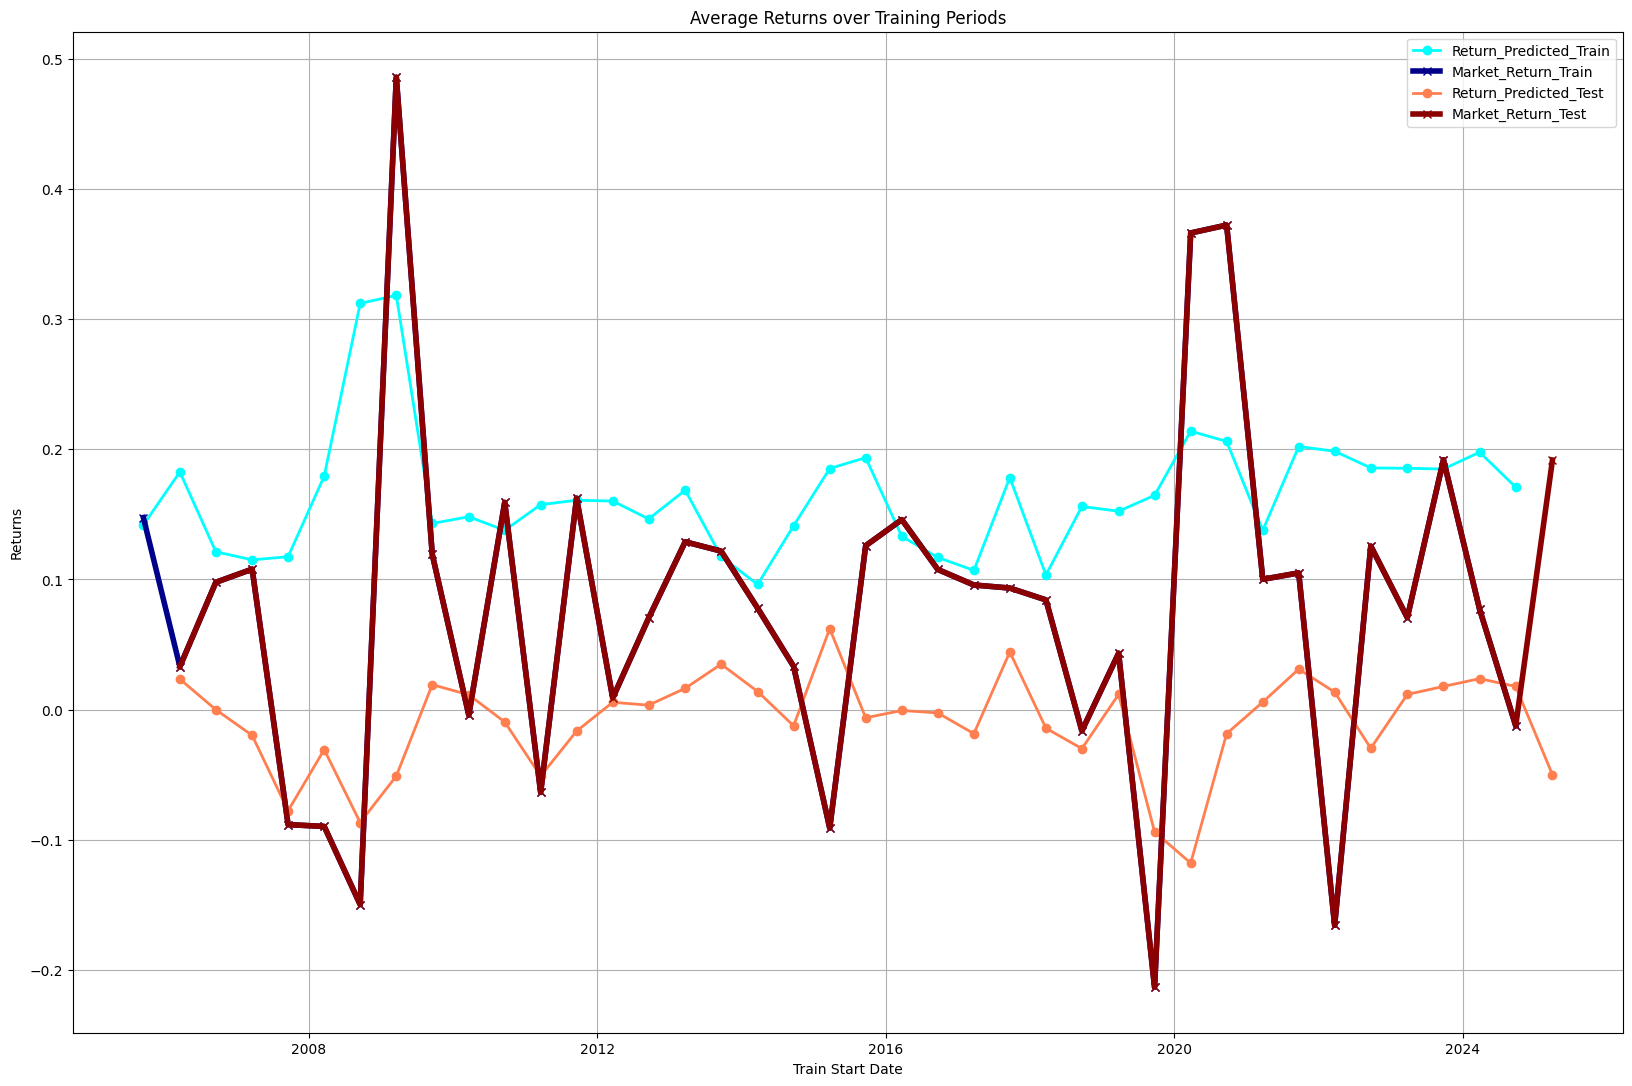

In [7]:
linewidth_market = 4
linewidth_model = 2
plt.figure(figsize=(20, 13))
plt.plot(summary_graph_raw.index.get_level_values('Train Start'), summary_graph_raw['Return_Predicted_Train'], label='Return_Predicted_Train', marker='o', linewidth=linewidth_model, color='cyan')
plt.plot(summary_graph_raw.index.get_level_values('Train Start'), summary_graph_raw['Market_Return_Train'], label='Market_Return_Train', marker='x', linewidth=linewidth_market, color='darkblue')
plt.plot(summary_graph_raw.index.get_level_values('Test Start'), summary_graph_raw['Return_Predicted_Test'], label='Return_Predicted_Test', marker='o', linewidth=linewidth_model, color='coral')
plt.plot(summary_graph_raw.index.get_level_values('Test Start'), summary_graph_raw['Market_Return_Test'], label='Market_Return_Test', marker='x', linewidth=linewidth_market, color='darkred')
plt.xlabel('Train Start Date')
plt.ylabel('Returns')
plt.title('Average Returns over Training Periods')
plt.legend()
plt.grid()
plt.show()

In [8]:
# Compute yield and std for each series from summary_graph

for serie in ['Return_Predicted_Train', 'Market_Return_Train', 'Return_Predicted_Test', 'Market_Return_Test']:
    yields_raw = summary_graph_raw[serie].values
    mean_yield_raw = np.mean(yields_raw)
    std_yield_raw = np.std(yields_raw)
    sharpe_ratio_raw = mean_yield_raw / std_yield_raw if std_yield_raw != 0 else 0
    print(f"{serie} - Mean Yield: {mean_yield_raw:.4f}, Std Dev: {std_yield_raw:.4f}, Sharpe Ratio: {sharpe_ratio_raw:.4f}")

Return_Predicted_Train - Mean Yield: 0.1651, Std Dev: 0.0464, Sharpe Ratio: 3.5554
Market_Return_Train - Mean Yield: 0.0760, Std Dev: 0.1360, Sharpe Ratio: 0.5593
Return_Predicted_Test - Mean Yield: -0.0094, Std Dev: 0.0380, Sharpe Ratio: -0.2484
Market_Return_Test - Mean Yield: 0.0772, Std Dev: 0.1367, Sharpe Ratio: 0.5645


In [9]:
# Compute P&L evolution over time for each series
Start_dates = summary_graph_raw.index.get_level_values('Test Start')
End_dates = summary_graph_raw.index.get_level_values('Test End')

Start_End_dates = zip(Start_dates, End_dates)
# Compute P&L evolution over time for each series
PNL_data_raw = summary_graph_raw.reset_index()[['Test Start', 'Test End', 'Return_Predicted_Train', 'Market_Return_Train', 'Return_Predicted_Test', 'Market_Return_Test']].rename(columns={'Test Start': 'Start', 'Test End': 'End'})
for start, end in Start_End_dates:
    for serie in ['Return_Predicted_Train', 'Market_Return_Train', 'Return_Predicted_Test', 'Market_Return_Test']:
        PNL_data_raw.loc[(PNL_data_raw['Start'] == start) & (PNL_data_raw['End'] == end), serie] = summary_graph_raw.loc[(summary_graph_raw.index.get_level_values('Test Start') == start) & (summary_graph_raw.index.get_level_values('Test End') == end), serie].values[0]

for serie in ['Return_Predicted_Train', 'Market_Return_Train', 'Return_Predicted_Test', 'Market_Return_Test']:
    PNL_data_raw[serie] = np.exp(PNL_data_raw[serie])
    PNL_data_raw[serie] = PNL_data_raw[serie].cumprod()

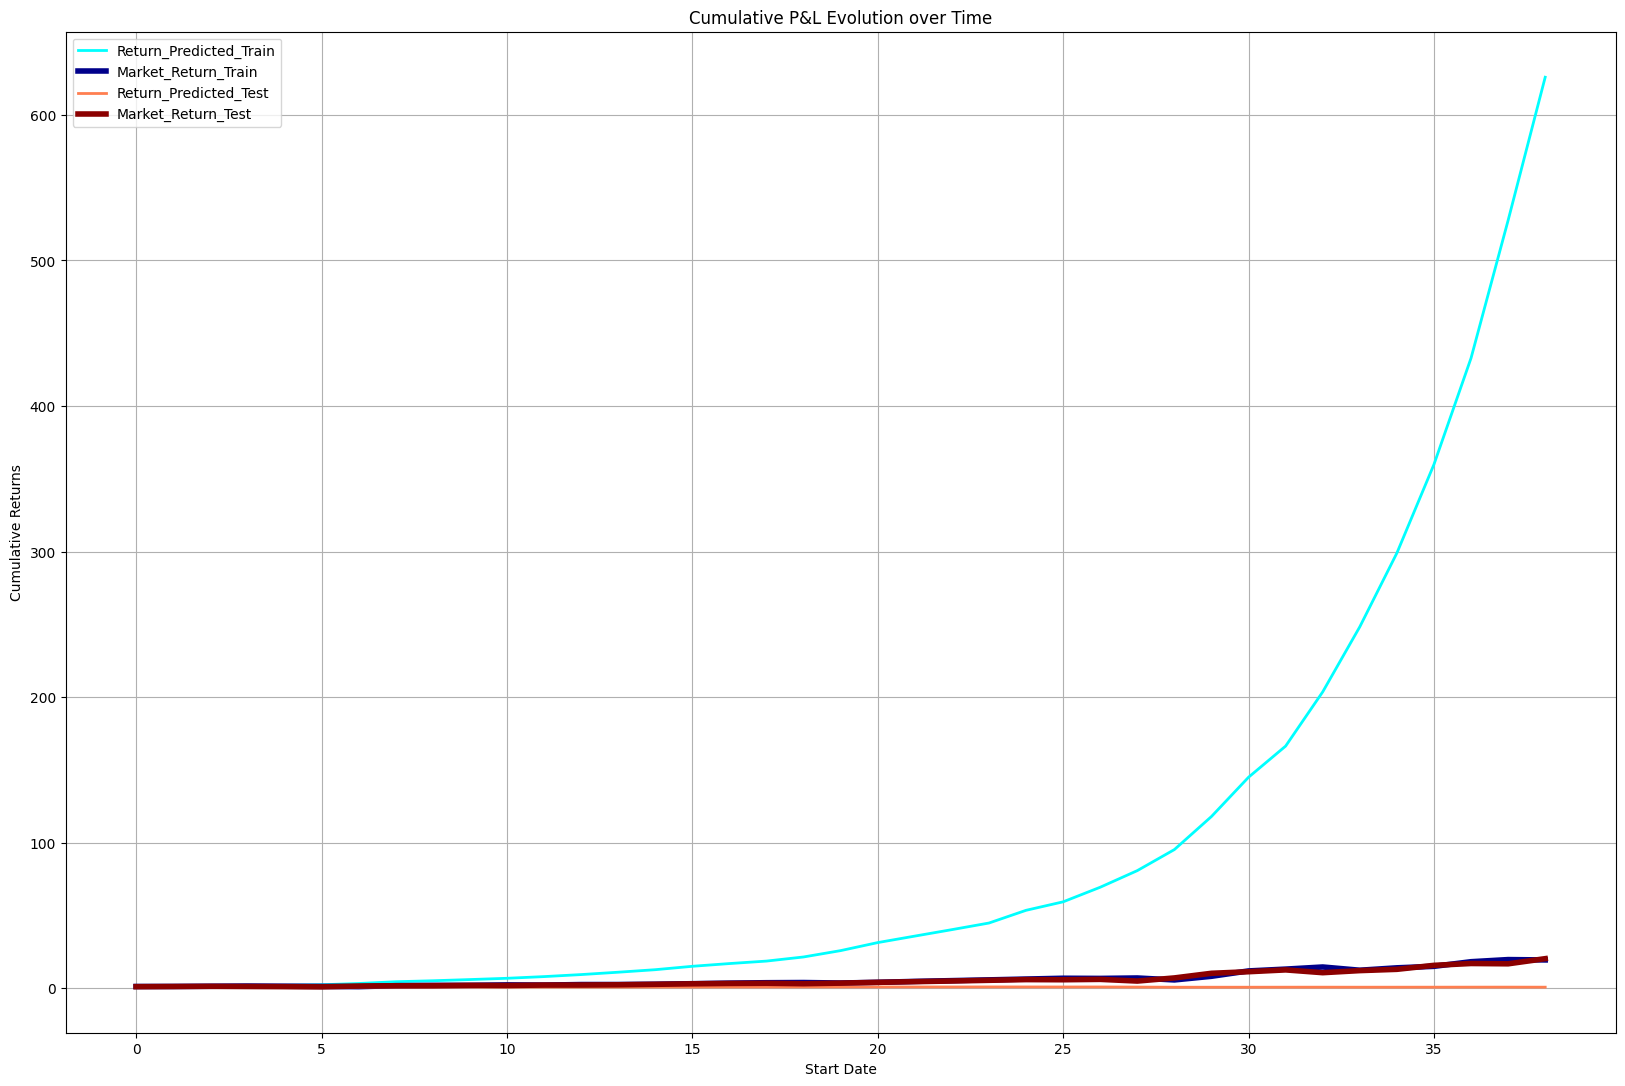

,Start,End,Return_Predicted_Train,Market_Return_Train,Return_Predicted_Test,Market_Return_Test
0,2006-03-20,2006-09-15,1.152491,1.159029,1.023724,1.033638
1,2006-09-18,2007-03-20,1.383347,1.198016,1.023737,1.139854
2,2007-03-21,2007-09-18,1.561737,1.321124,1.003723,1.269765
3,2007-09-19,2008-03-19,1.752186,1.471695,0.928727,1.162464
4,2008-03-20,2008-09-17,1.970603,1.347330,0.900694,1.062746
5,2008-09-18,2009-03-19,2.357865,1.231754,0.825893,0.914978
6,2009-03-20,2009-09-17,3.221303,1.060486,0.784867,1.487220
7,2009-09-18,2010-03-19,4.428250,1.723731,0.800081,1.675695
8,2010-03-22,2010-09-17,5.109220,1.942180,0.809264,1.668791
9,2010-09-20,2011-03-18,5.925318,1.934177,0.801662,1.956760


In [10]:
#PNL_data.set_index('Start', inplace=True)
linewidth_market = 4
linewidth_model = 2
plt.figure(figsize=(20, 13))
plt.plot(PNL_data_raw.index, PNL_data_raw['Return_Predicted_Train'], label='Return_Predicted_Train', linewidth=linewidth_model, color='cyan')
plt.plot(PNL_data_raw.index, PNL_data_raw['Market_Return_Train'], label='Market_Return_Train', linewidth=linewidth_market, color='darkblue')
plt.plot(PNL_data_raw.index, PNL_data_raw['Return_Predicted_Test'], label='Return_Predicted_Test', linewidth=linewidth_model, color='coral')
plt.plot(PNL_data_raw.index, PNL_data_raw['Market_Return_Test'], label='Market_Return_Test', linewidth=linewidth_market, color='darkred')
plt.xlabel('Start Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative P&L Evolution over Time')
plt.legend()
plt.grid()
plt.show()
PNL_data_raw

In [11]:
Train_start_list = metrics_perf_df['Train Start'].unique().tolist()
Ticker_per_Period = {}

quantile_above = 0.75
for train_start in Train_start_list:
    quantile_n = metrics_perf_df[metrics_perf_df['Train Start'] == train_start].Ratio_Train.quantile(quantile_above)
    selected_tickers = metrics_perf_df[(metrics_perf_df['Train Start'] == train_start) &
                                       (metrics_perf_df['Ratio_Train'] >= quantile_n)]['Ticker'].tolist()
    Ticker_per_Period[train_start] = selected_tickers

print("Selected Tickers per Training Period:")
for period, tickers in Ticker_per_Period.items():
    print(f"{period}: {tickers}")

Selected Tickers per Training Period:
2005-09-16 00:00:00: ['FHN', 'ERIC', 'MCHP', 'FE', 'EQT', 'INFY', 'CNC', 'MDLZ', 'MSFT', 'TU', 'MRVL', 'EXC', 'MU', 'C', 'DVN', 'PFE', 'CCL', 'HAL', 'LOW', 'WDC', 'EXAS', 'BKR', 'LEN', 'KO', 'BP', 'JHX', 'ITUB', 'VZ', 'BBD', 'BB', 'LNW', 'ES', 'AZN', 'TGT', 'T']
2006-03-20 00:00:00: ['ASX', 'NVDA', 'MDLZ', 'GSK', 'TXN', 'KGC', 'PLUG', 'FCX', 'AMAT', 'HBAN', 'F', 'TSM', 'CTRA', 'WMT', 'APH', 'MS', 'PFE', 'B', 'CSX', 'MNST', 'NGD', 'HL', 'BKR', 'CPRT', 'ITUB', '^VIX', 'SHEL', 'BCS', 'LYG', 'BB', 'CCJ', 'IRM', 'ON', 'TGT', 'LRCX']
2006-09-18 00:00:00: ['AMZN', 'ERIC', 'MRK', 'MCHP', 'KEY', 'MDT', 'GSK', 'EQNR', 'AMAT', 'F', 'BAC', 'QCOM', 'EXC', 'C', 'APH', 'MS', 'HAL', 'CSX', 'NOK', 'HD', 'VLY', 'UNH', 'EXAS', 'BKR', 'LEN', 'XOM', 'ABT', '^VIX', 'CNQ', 'TEVA', 'USB', 'LNW', 'CCJ', 'CRM', 'NFLX']
2007-03-21 00:00:00: ['ASX', 'MRK', 'CAG', 'MCHP', 'FE', 'EQT', 'TXN', 'GGB', 'KGC', 'ABEV', 'EQNR', 'AAPL', 'IAG', 'F', 'TU', 'CTRA', 'DVN', 'MS', 'CCL', 'B

In [12]:

tscv_selected = TimeSeriesSplit(n_splits=tscv_nSplit, max_train_size=window_size)

metrics_perf_selected = []
current_step_selected = 0
total_steps_selected = tscv_selected.get_n_splits(filtered_data)

for train_index, test_index in tscv_selected.split(filtered_data):
    print(f'Processing fold {current_step_selected + 1} of {total_steps_selected}')
    current_step_selected += 1

    train_data, test_data = filtered_data.iloc[train_index], filtered_data.iloc[test_index]
    tickers_in_period = Ticker_per_Period.get(train_data.index.min(), [])
    for ticker in tickers_in_period:
        X_train, Y_train = train_data[ticker].drop(columns=['Signal']), train_data[ticker]['Signal']
        X_test, Y_test = test_data[ticker].drop(columns=['Signal']), test_data[ticker]['Signal']

        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Fit linear regression model
        model = LinearRegression()
        model.fit(X_train_scaled, Y_train)

        # Make predictions
        Y_train_pred_src = model.predict(X_train_scaled)
        Y_test_pred_src = model.predict(X_test_scaled)

        # Use optimal triggers based on previous model performance
        best_trigger_up = metrics_perf_df[(metrics_perf_df['Ticker'] == ticker) &
                                          (metrics_perf_df['Train Start'] == train_data.index.min())]['Trigger_Up'].values[0]
        best_trigger_down = metrics_perf_df[(metrics_perf_df['Ticker'] == ticker) &
                                            (metrics_perf_df['Train Start'] == train_data.index.min())]['Trigger_Down'].values[0]

    
        # Define performance metrics (model returns based on triggers)
        Y_train_pred = np.where(Y_train_pred_src > best_trigger_up, 1, np.where(Y_train_pred_src < best_trigger_down, -1, 0))
        Y_test_pred = np.where(Y_test_pred_src > best_trigger_up, 1, np.where(Y_test_pred_src < best_trigger_down, -1, 0))
        #Y_train_pred = np.where(Y_train_pred_src > best_trigger_up, -1, np.where(Y_train_pred_src < best_trigger_down, 1, 0))
        #Y_test_pred = np.where(Y_test_pred_src > best_trigger_up, -1, np.where(Y_test_pred_src < best_trigger_down, 1, 0))
        
        # Evaluate performance
        Return = np.array(X_test.DD_Return.shift(-1).fillna(0))

        return_predicted_train = float(np.sum(Y_train_pred * X_train.DD_Return.shift(-1).fillna(0)))
        return_predicted_test = float(np.sum(Y_test_pred * Return))

        market_return_train = float(np.sum(X_train.DD_Return.shift(-1).fillna(0)))
        market_return_test = float(np.sum(Return))

        ratio_train = return_predicted_train / market_return_train if market_return_train != 0 else 0
        ratio_test = return_predicted_test / market_return_test if market_return_test != 0 else 0    
              
        
        metrics_perf_selected.append({
            'Ticker': ticker,
            'Train Start': train_data.index.min(),
            'Train End': train_data.index.max(),
            'Test Start': test_data.index.min(),
            'Test End': test_data.index.max(),
            'Return_Predicted_Train': return_predicted_train,
            'Return_Predicted_Test': return_predicted_test,
            'Market_Return_Train': market_return_train,
            'Market_Return_Test': market_return_test,
            'Ratio_Train': ratio_train,
            'Ratio_Test': ratio_test,
            'Model_train_>_Market_train': 1 if return_predicted_train > market_return_train else 0,
            'Model_test_>_Market_test': 1 if return_predicted_test > market_return_test else 0,
            'Trigger_Up': best_trigger_up,
            'Trigger_Down': best_trigger_down,
        })

metrics_perf_selected_df = pd.DataFrame(metrics_perf_selected)
metrics_perf_selected_df.to_csv('model/linear/metrics_selected_data.csv', index=False)
metrics_perf_selected_df

Processing fold 1 of 39
Processing fold 2 of 39
Processing fold 3 of 39
Processing fold 4 of 39
Processing fold 5 of 39
Processing fold 6 of 39
Processing fold 7 of 39
Processing fold 8 of 39
Processing fold 9 of 39
Processing fold 10 of 39
Processing fold 11 of 39
Processing fold 12 of 39
Processing fold 13 of 39
Processing fold 14 of 39
Processing fold 15 of 39
Processing fold 16 of 39
Processing fold 17 of 39
Processing fold 18 of 39
Processing fold 19 of 39
Processing fold 20 of 39
Processing fold 21 of 39
Processing fold 22 of 39
Processing fold 23 of 39
Processing fold 24 of 39
Processing fold 25 of 39
Processing fold 26 of 39
Processing fold 27 of 39
Processing fold 28 of 39
Processing fold 29 of 39
Processing fold 30 of 39
Processing fold 31 of 39
Processing fold 32 of 39
Processing fold 33 of 39
Processing fold 34 of 39
Processing fold 35 of 39
Processing fold 36 of 39
Processing fold 37 of 39
Processing fold 38 of 39
Processing fold 39 of 39


,Ticker,Train Start,Train End,Test Start,Test End,Return_Predicted_Train,Return_Predicted_Test,Market_Return_Train,Market_Return_Test,Ratio_Train,Ratio_Test,Model_train_>_Market_train,Model_test_>_Market_test,Trigger_Up,Trigger_Down
0,FHN,2005-09-16,2006-03-17,2006-03-20,2006-09-15,0.165835,-0.061667,0.099443,-0.019505,1.667636,3.161594,1,0,0.000000,0.000000
1,ERIC,2005-09-16,2006-03-17,2006-03-20,2006-09-15,0.105230,0.137454,0.050142,-0.073038,2.098623,-1.881958,1,1,0.555556,0.000000
2,MCHP,2005-09-16,2006-03-17,2006-03-20,2006-09-15,0.361248,-0.003122,0.175086,-0.000126,2.063262,24.683234,1,0,0.000000,0.000000
3,FE,2005-09-16,2006-03-17,2006-03-20,2006-09-15,0.028366,-0.150083,0.006944,0.114668,4.085272,-1.308852,1,0,0.555556,-1.666667
4,EQT,2005-09-16,2006-03-17,2006-03-20,2006-09-15,0.025956,0.006364,0.005566,-0.026739,4.663551,-0.238010,1,1,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1421,BSX,2024-09-26,2025-03-28,2025-03-31,2025-09-29,0.171066,0.075840,0.189197,-0.023026,0.904166,-3.293692,0,1,0.000000,-1.111111
1422,CVX,2024-09-26,2025-03-28,2025-03-31,2025-09-29,0.194794,0.154908,0.188360,-0.025682,1.034156,-6.031694,1,1,0.000000,0.000000
1423,BBWI,2024-09-26,2025-03-28,2025-03-31,2025-09-29,0.195280,-0.628490,0.046429,-0.058939,4.205989,10.663438,1,0,0.000000,0.000000
1424,TJX,2024-09-26,2025-03-28,2025-03-31,2025-09-29,0.148204,0.044371,0.013795,0.179216,10.743195,0.247585,1,0,0.000000,0.000000


In [13]:
# lets compute the average Return_Predicted_Train and Return_Predicted_Test for Train Start dates batch
summary_graph_selected = metrics_perf_selected_df.groupby(['Train Start', 'Train End', 'Test Start', 'Test End']).agg({
    'Return_Predicted_Train': 'mean',
    'Market_Return_Train': 'mean',
    'Return_Predicted_Test': 'mean',
    'Market_Return_Test': 'mean',
})
summary_graph_selected.to_csv('model/linear/metrics_selected_summary.csv', index=True)
summary_graph_selected

,,,,Return_Predicted_Train,Market_Return_Train,Return_Predicted_Test,Market_Return_Test
Train Start,Train End,Test Start,Test End,,,,
2005-09-16,2006-03-17,2006-03-20,2006-09-15,0.226222,0.118862,0.010126,0.015067
2006-03-20,2006-09-15,2006-09-18,2007-03-20,0.257785,0.098529,-0.022443,0.105713
2006-09-18,2007-03-20,2007-03-21,2007-09-18,0.217533,0.096994,-0.046544,0.129330
2007-03-21,2007-09-18,2007-09-19,2008-03-19,0.193952,0.144257,-0.009580,-0.052178
2007-09-19,2008-03-19,2008-03-20,2008-09-17,0.064045,0.128880,-0.059482,-0.087848
2008-03-20,2008-09-17,2008-09-18,2009-03-19,0.156350,0.092842,-0.078063,-0.271282
2008-09-18,2009-03-19,2009-03-20,2009-09-17,0.270276,0.083741,0.004168,0.404828
2009-03-20,2009-09-17,2009-09-18,2010-03-19,0.593886,0.466654,0.015333,0.132621
2009-09-18,2010-03-19,2010-03-22,2010-09-17,0.206187,0.101299,0.048270,0.012378


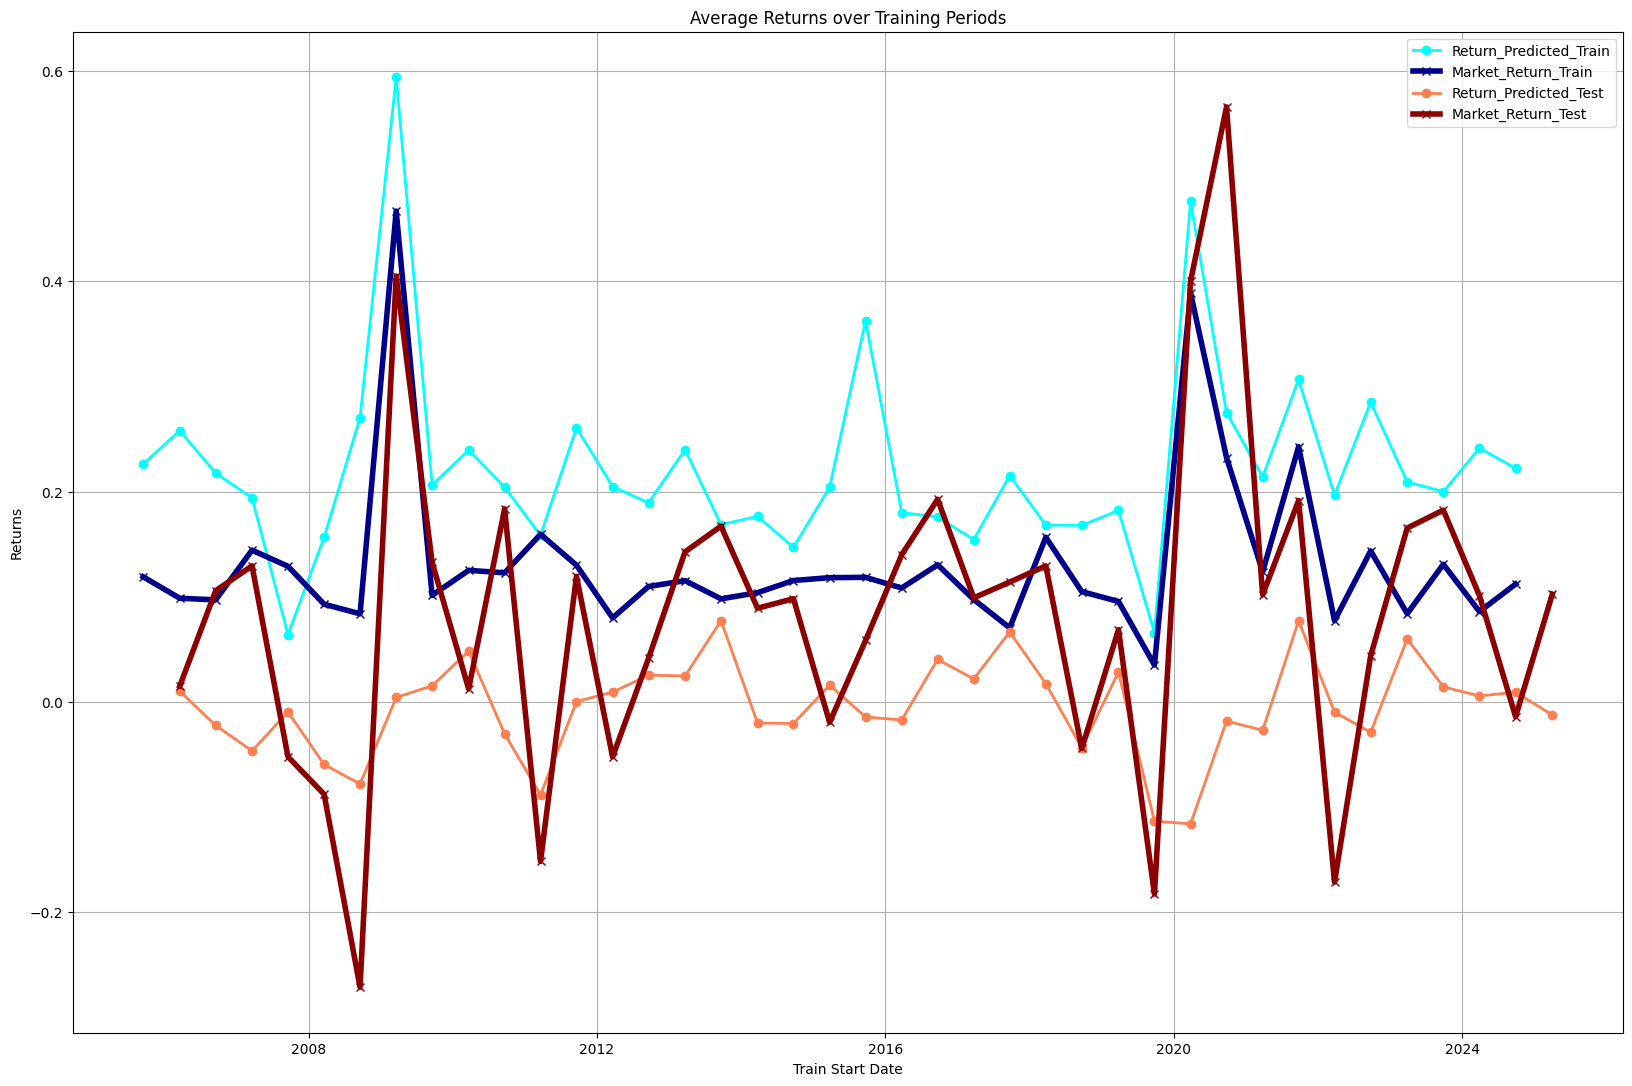

In [14]:
linewidth_market = 4
linewidth_model = 2
plt.figure(figsize=(20, 13))
plt.plot(summary_graph_selected.index.get_level_values('Train Start'), summary_graph_selected['Return_Predicted_Train'], label='Return_Predicted_Train', marker='o', linewidth=linewidth_model, color='cyan')
plt.plot(summary_graph_selected.index.get_level_values('Train Start'), summary_graph_selected['Market_Return_Train'], label='Market_Return_Train', marker='x', linewidth=linewidth_market, color='darkblue')
plt.plot(summary_graph_selected.index.get_level_values('Test Start'), summary_graph_selected['Return_Predicted_Test'], label='Return_Predicted_Test', marker='o', linewidth=linewidth_model, color='coral')
plt.plot(summary_graph_selected.index.get_level_values('Test Start'), summary_graph_selected['Market_Return_Test'], label='Market_Return_Test', marker='x', linewidth=linewidth_market, color='darkred')
plt.xlabel('Train Start Date')
plt.ylabel('Returns')
plt.title('Average Returns over Training Periods')
plt.legend()
plt.grid()
plt.show()

In [15]:
# Compute yield and std for each series from summary_graph

for serie in ['Return_Predicted_Train', 'Market_Return_Train', 'Return_Predicted_Test', 'Market_Return_Test']:
    yields = summary_graph_selected[serie].values
    mean_yield = np.mean(yields)
    std_yield = np.std(yields)
    sharpe_ratio = mean_yield / std_yield if std_yield != 0 else 0
    print(f"{serie} - Mean Yield: {mean_yield:.4f}, Std Dev: {std_yield:.4f}, Sharpe Ratio: {sharpe_ratio:.4f}")


Return_Predicted_Train - Mean Yield: 0.2224, Std Dev: 0.0922, Sharpe Ratio: 2.4133
Market_Return_Train - Mean Yield: 0.1320, Std Dev: 0.0785, Sharpe Ratio: 1.6811
Return_Predicted_Test - Mean Yield: -0.0053, Std Dev: 0.0451, Sharpe Ratio: -0.1166
Market_Return_Test - Mean Yield: 0.0833, Std Dev: 0.1556, Sharpe Ratio: 0.5355


In [16]:
# Compute P&L evolution over time for each series
Start_dates = summary_graph_selected.index.get_level_values('Test Start')
End_dates = summary_graph_selected.index.get_level_values('Test End')

Start_End_dates = zip(Start_dates, End_dates)
# Compute P&L evolution over time for each series
PNL_data = summary_graph_selected.reset_index()[['Test Start', 'Test End', 'Return_Predicted_Train', 'Market_Return_Train', 'Return_Predicted_Test', 'Market_Return_Test']].rename(columns={'Test Start': 'Start', 'Test End': 'End'})
for start, end in Start_End_dates:
    for serie in ['Return_Predicted_Train', 'Market_Return_Train', 'Return_Predicted_Test', 'Market_Return_Test']:
        PNL_data.loc[(PNL_data['Start'] == start) & (PNL_data['End'] == end), serie] = summary_graph_selected.loc[(summary_graph_selected.index.get_level_values('Test Start') == start) & (summary_graph_selected.index.get_level_values('Test End') == end), serie].values[0]

for serie in ['Return_Predicted_Train', 'Market_Return_Train', 'Return_Predicted_Test', 'Market_Return_Test']:
    PNL_data[serie] = np.exp(PNL_data[serie])
    PNL_data[serie] = PNL_data[serie].cumprod()

In [17]:
PNL_data.to_csv('model/linear/PNL_selected_data.csv', index=False)

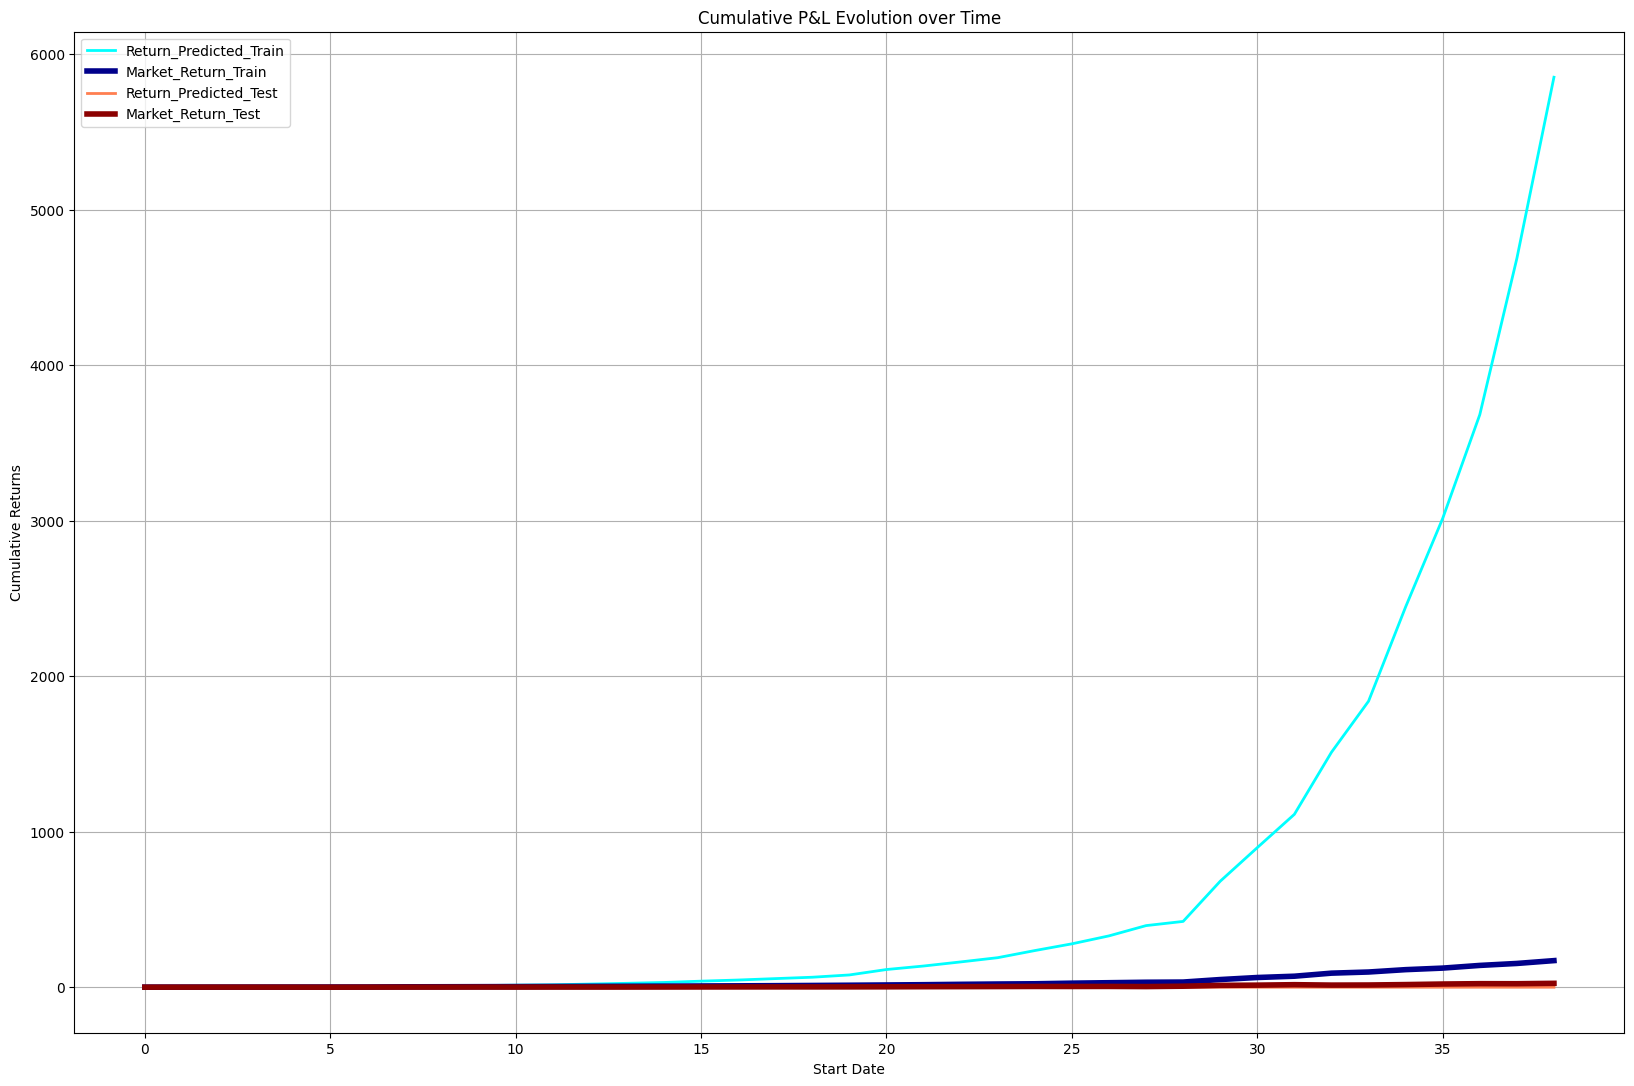

,Start,End,Return_Predicted_Train,Market_Return_Train,Return_Predicted_Test,Market_Return_Test
0,2006-03-20,2006-09-15,1.253854,1.126215,1.010178,1.015181
1,2006-09-18,2007-03-20,1.622562,1.242830,0.987758,1.128376
2,2007-03-21,2007-09-18,2.016855,1.369416,0.942838,1.284166
3,2007-09-19,2008-03-19,2.448538,1.581923,0.933848,1.218879
4,2008-03-20,2008-09-17,2.610486,1.799523,0.879921,1.116371
5,2008-09-18,2009-03-19,3.052271,1.974596,0.813844,0.851123
6,2009-03-20,2009-09-17,3.999471,2.147071,0.817243,1.275872
7,2009-09-18,2010-03-19,7.243090,3.423826,0.829871,1.456812
8,2010-03-22,2010-09-17,8.901637,3.788833,0.870911,1.474958
9,2010-09-20,2011-03-18,11.308304,4.293502,0.844889,1.772080


In [18]:
linewidth_market = 4
linewidth_model = 2
plt.figure(figsize=(20, 13))
plt.plot(PNL_data.index, PNL_data['Return_Predicted_Train'], label='Return_Predicted_Train', linewidth=linewidth_model, color='cyan')
plt.plot(PNL_data.index, PNL_data['Market_Return_Train'], label='Market_Return_Train', linewidth=linewidth_market, color='darkblue')
plt.plot(PNL_data.index, PNL_data['Return_Predicted_Test'], label='Return_Predicted_Test', linewidth=linewidth_model, color='coral')
plt.plot(PNL_data.index, PNL_data['Market_Return_Test'], label='Market_Return_Test', linewidth=linewidth_market, color='darkred')
plt.xlabel('Start Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative P&L Evolution over Time')
plt.legend()
plt.grid()
plt.show()
PNL_data

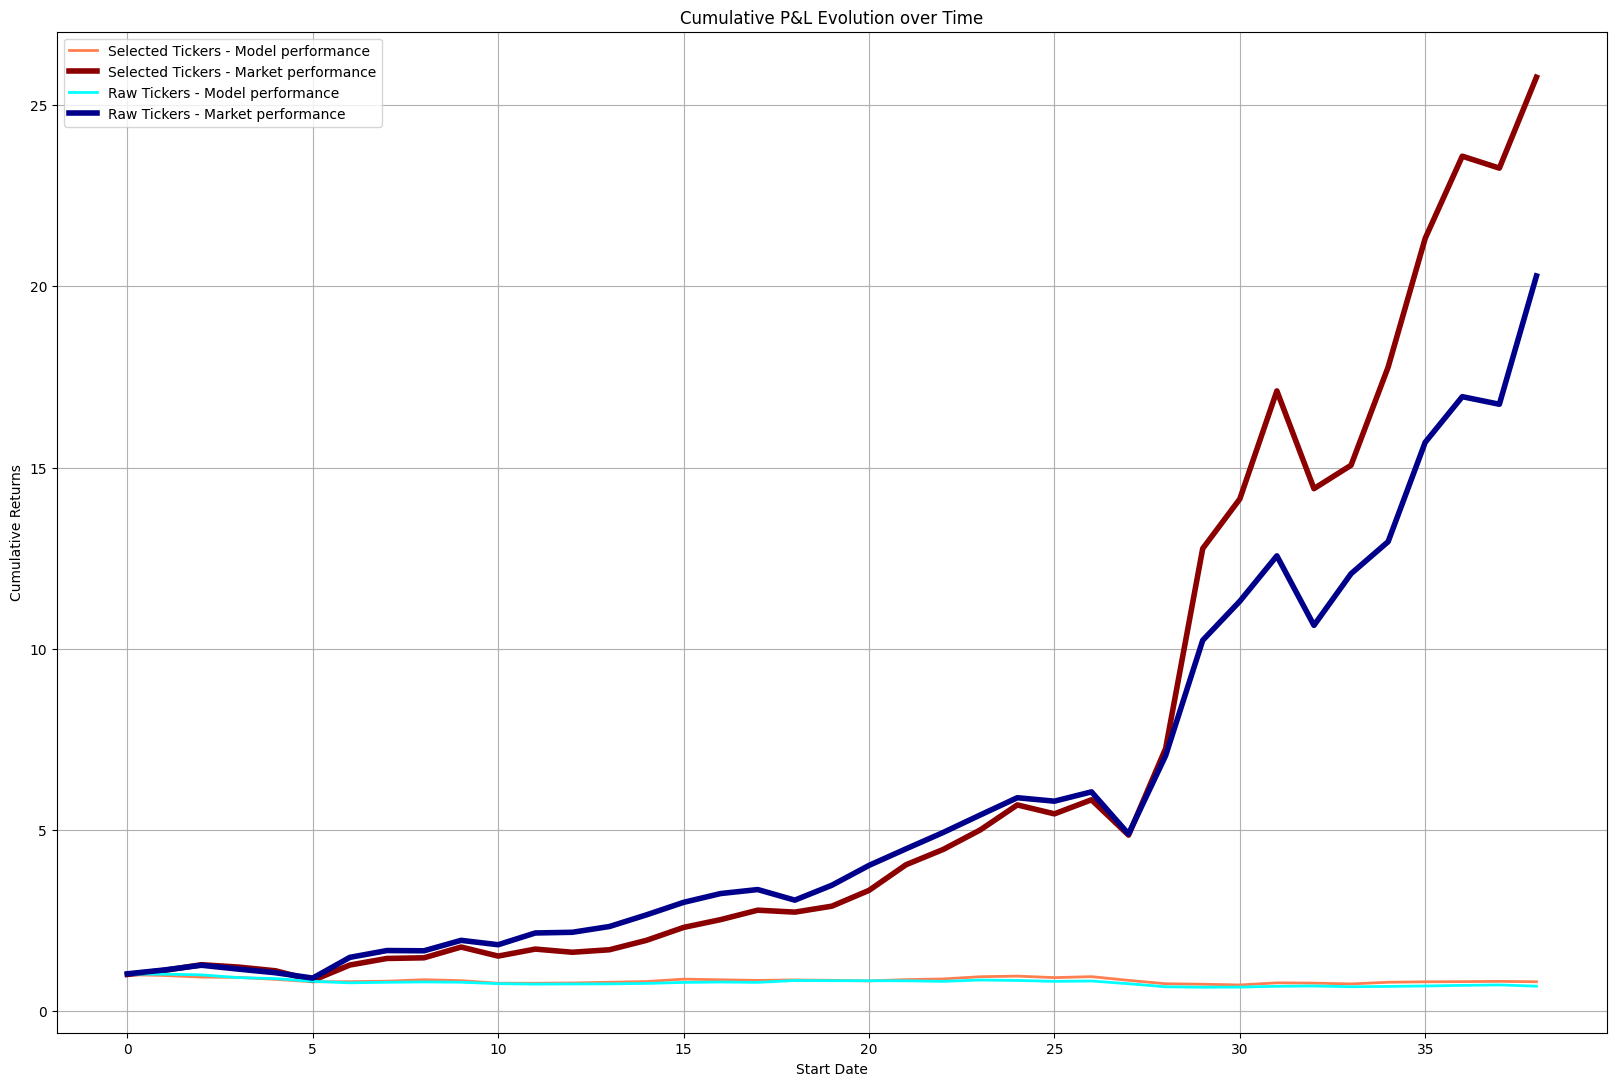

In [19]:
# Compare PNL data between raw and selected tickers

plt.figure(figsize=(20, 13))

plt.plot(PNL_data.index, PNL_data['Return_Predicted_Test'], label='Selected Tickers - Model performance', linewidth=linewidth_model, color='coral')
plt.plot(PNL_data.index, PNL_data['Market_Return_Test'], label='Selected Tickers - Market performance', linewidth=linewidth_market, color='darkred')

plt.plot(PNL_data_raw.index, PNL_data_raw['Return_Predicted_Test'], label='Raw Tickers - Model performance', linewidth=linewidth_model, color='cyan')
plt.plot(PNL_data_raw.index, PNL_data_raw['Market_Return_Test'], label='Raw Tickers - Market performance', linewidth=linewidth_market, color='darkblue')

plt.xlabel('Start Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative P&L Evolution over Time')
plt.legend()
plt.grid()
plt.show()
